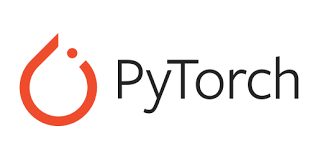

# Masked Language Model.

In MLM we input a sentence and optimize model weight to get the same output. But before sending input we randomly masked some tokens with [Mask] token. To train the MLM model we need to follow few steps
* Tokenize input.
* Create a label with input or clone input tensor.
* Randomly masked some token in input.
* Initialize the model and calculate the loss.
* Finally update weight.

In [14]:
!pip install torch

# Tokenizer and Dataset

We will be using BertTokenizer from transformers and create our own PyTorch Dataset class.

In [3]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_basic_tokenization = True)

In [15]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

def data_collate_fn(dataset_samples_list):
    arr = np.array(dataset_samples_list)
    inputs = tokenizer(text=arr.tolist(), padding='max_length', max_length=30, return_tensors='pt')
    return inputs

class MyDataset(Dataset):
    def __init__(self, src, tokenizer):
        self.src = src
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src = self.src[idx]
        return src

# Model

We are using model code from PyTorch [LANGUAGE MODELING WITH NN.TRANSFORMER AND TORCHTEXT](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) tutorial.

In [16]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

device = "cuda" if torch.cuda.is_available() else "cpu"


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [17]:
def train(model, dataloader):
    model.train()
    epochs = 500
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        for batch in dataloader:
            optim.zero_grad()
            input = batch['input_ids'].clone()
            src_mask = model.generate_square_subsequent_mask(batch['input_ids'].size(1))
            rand_value = torch.rand(batch.input_ids.shape)
            rand_mask = (rand_value < 0.15) * (input != 101) * (input != 102) * (input != 0)
            mask_idx=(rand_mask.flatten() == True).nonzero().view(-1)
            input = input.flatten()
            input[mask_idx] = 103
            input = input.view(batch['input_ids'].size())

            out = model(input.to(device), src_mask.to(device))
            loss = criterion(out.view(-1, ntokens), batch['input_ids'].view(-1).to(device))
            total_loss += loss
            loss.backward()
            optim.step()
    
        if (epoch+1)%40==0 or epoch==0:
            print("Epoch: {} -> loss: {}".format(epoch+1, total_loss/(len(dataloader)*epoch+1)))


def predict(model, input):
    model.eval()
    src_mask = model.generate_square_subsequent_mask(input.size(1))
    out = model(input.to(device), src_mask.to(device))
    out = out.topk(1).indices.view(-1)
    return out

Some texts for train model. Creating dataset and dataloader instances.

In [18]:
text = ["Don't speak ill of others.",
"To speak ill of others is a great crime.",
"Rather rectify yourself through self-criticism.",
"In this way, if you rectify yourself, others will follow you.",
"To speak ill of others gives rise to more problems.",
"This does not do any good to society.",
"More than 80 percent people of our country live in villages.",
"Most of them are poor and illiterate.",
"Illiteracy is one of the causes of their poverty.",
"Many of the villagers are landless cultivators.",
"They cultivate the lands of other people throughout the year.",
"They get a very small portion of the crops.",
"They provide all of us with food.",
"But in want they only starve.",
"They suffer most.",
"The situation needs to be changed.",
"We live in the age of science.",
"We can see the influence of science everywhere.",
"Science is a constant companion of our life.",
"We have made the impossible things possible with the help of science.",
"Modern civilization is a contribution of science.",
"Science should be devoted to the greater welfare of mankind.",
"Rabindranath Tagore got the Nobel Prize in 1913 which is 98 years ago from today.",
"He was awarded this prize for the translation of the Bengali 'Gitanjali' into English.",
"This excellent rendering was the poet's own.",
"In the English version of Gitanjali there are 103 songs."]

dataset = MyDataset(text, tokenizer)
dataloader = DataLoader(dataset, batch_size=4, collate_fn=data_collate_fn)

Initialize model

In [19]:
ntokens = tokenizer.vocab_size # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [20]:
# Training Model

train(model, dataloader)

In [ ]:
# Predict

print("Input: {}".format(text[0]))
pred_inp = tokenizer("Don't speak ill of [MASK].", return_tensors='pt')
out = predict(model, pred_inp['input_ids'])
print("Output: {}\n".format(tokenizer.decode(out)))

# References
* [Masked-Language Modeling With BERT](https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c)
* [LANGUAGE MODELING WITH NN.TRANSFORMER AND TORCHTEXT](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)